# Plant Disease Detection using Transfer Learning

## Project Overview
This project applies deep learning and transfer learning techniques to identify plant leaf diseases using the **PlantVillage** dataset. The goal is to build a model that can accurately classify crop diseases, aiding early detection and improving agricultural productivity.

## Objective
To develop a multi-class image classification model using a pre-trained convolutional neural network (CNN) — such as **VGG16** — that can:
- Identify 38 different plant disease categories (including healthy leaves)
- Achieve high validation accuracy with efficient training
- Generalize well to unseen images through proper data augmentation and fine-tuning

## Real-World Relevance
Agriculture plays a crucial role in global food security. Timely and accurate disease diagnosis:
- Reduces pesticide misuse
- Prevents crop loss
- Improves yield and sustainability
This project demonstrates how transfer learning can enable practical solutions even with limited agricultural datasets.

## Dataset: PlantVillage
- Total images: ~54,000
- Number of classes: 38 (healthy + various diseases across multiple crops)
- Image format: RGB
- Source: [Kaggle - PlantVillage Dataset](https://www.kaggle.com/datasets/emmarex/plantdisease)

## Tools & Libraries
- Python, TensorFlow / Keras
- Pre-trained CNNs (VGG16)
- Matplotlib, Seaborn for visualization
- scikit-learn for performance metrics

## Workflow
1. **Data Preprocessing**: Load and augment dataset
2. **Model Setup**: Use transfer learning with a frozen base model + custom classifier
3. **Training**
4. **Evaluation**: Assess model with accuracy and loss trend and classification report
5. **Interpretation**: Analyze misclassifications and discuss potential improvements

## Expected Outcome
- Classification accuracy ≥90%
- A lightweight, generalizable image classifier
- Actionable insights for deployment in agricultural decision-making

---



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the PlantVillage dataset
# Split into 70% training, 15% validation, and 15% test
d_train, d_valid, d_test = tfds.load("plant_village",
                                     split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                     as_supervised=True)

# Display the number of examples in each subset
print('n_train =', tf.data.experimental.cardinality(d_train).numpy())
print('n_valid =', tf.data.experimental.cardinality(d_valid).numpy())
print('n_test =', tf.data.experimental.cardinality(d_test).numpy())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.GFJX3Q_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
n_train = 38012
n_valid = 8146
n_test = 8145


#See what we're working with

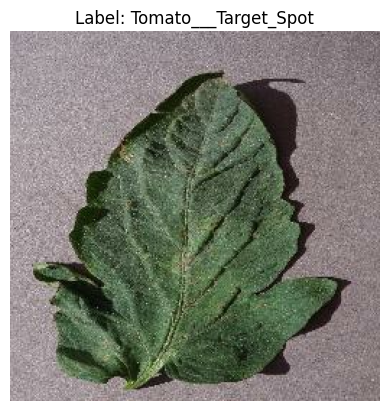

In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load one example with metadata
ds, ds_info = tfds.load("plant_village", split='train', as_supervised=True, with_info=True)
label_names = ds_info.features['label'].names

# Take one example
image, label = next(iter(ds))

# Display the image
plt.imshow(image)
plt.title(f"Label: {label_names[label.numpy()]}")
plt.axis('off')
plt.show()


#Preprocess data

VGG-16 expected 224 * 224 pixel img input

Apply data augmentation(flip, zoom in-out, brightness) for better generalization

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

#Optimizes the data pipeline performance by prefetching data asynchronously.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create zoom augmented layer -> randomly zoom in-out by20%, simulates the effect of getting closer or further from the subject
random_zoom = tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))


def preprocess_train(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)                              # Random horizontal flip augmentation
    image = tf.image.random_brightness(image, max_delta=0.2)                    # Random brightness adjustment

    # Apply random zoom with the layer (expand dims to batch dimension first)
    image = tf.expand_dims(image, 0)                                            # Add batch dimension
    image = random_zoom(image)
    image = tf.squeeze(image, 0)                                                # Remove batch dimension

    # Use VGG16 preprocessing (scaling, mean centering)
    image = preprocess_input(image)
    return image, label

def preprocess_val_test(image, label):                                          #Validation and test set must not be augmented
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    return image, label

# Load dataset splits
d_train, d_valid, d_test = tfds.load("plant_village",
                                     split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                     as_supervised=True)

# Prepare training dataset
d_train = d_train.map(preprocess_train, num_parallel_calls=AUTOTUNE)
d_train = d_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Prepare validation and test datasets
d_valid = d_valid.map(preprocess_val_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
d_test = d_test.map(preprocess_val_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


#Load VGG-16

In [ ]:
#load VGG16 as a base model
#use the weights trained by the imagenet dataset
base_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        input_shape = (224,224,3),
                                        include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Define the classification part

In [ ]:
#freeze the weight of VGG16
base_model.trainable = False

# Build classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
outputs = tf.keras.layers.Dense(38, activation='softmax')(x)                    # 38 classes in PlantVillage

# Define model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile with multiclass classification settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),                       # because labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,785,254 (56.40 MB)

 Trainable params: 70,566 (275.65 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#For the training process assign a variable to the result to keep track of the training

In [ ]:
history = model.fit(d_train, epochs = 20, batch_size = BATCH_SIZE,              #assign the training result to a variable to keep track of the training
          shuffle = True, validation_data = d_valid)

Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.2330 - loss: 2.9754 - val_accuracy: 0.5029 - val_loss: 1.8555
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.4531 - loss: 2.0179 - val_accuracy: 0.7237 - val_loss: 1.0153
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.6143 - loss: 1.3799 - val_accuracy: 0.8273 - val_loss: 0.5733
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.7341 - loss: 0.9240 - val_accuracy: 0.8961 - val_loss: 0.3390
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.8301 - loss: 0.5826 - val_accuracy: 0.9294 - val_loss: 0.2343
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.8779 - loss: 0.4135 - val_accuracy: 0.9580 - val_loss: 0.1448
Epoch 7/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.9127 - loss: 0.2954 - val_accuracy: 0.9586 - val_loss: 0.1488
Epoch 8/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.9336 -

#Let's see how we did on the first round

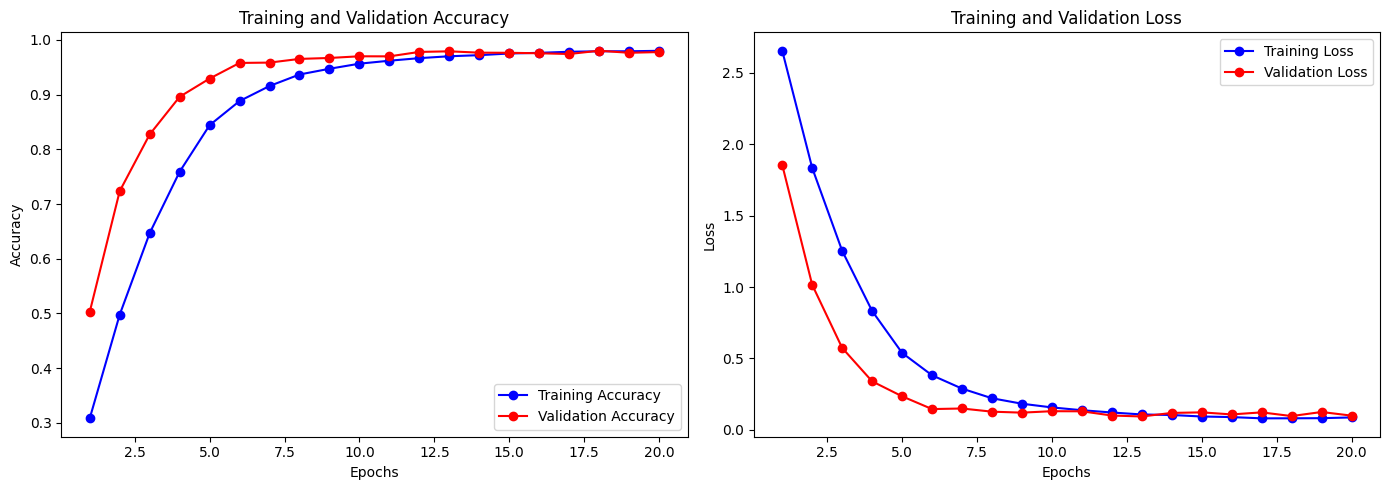

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#Let's analyze the result of our training

Quick look at the graph
the graphs look pretty healthy
1. The training and validation accuracy increase together and hit the plateau around the same point.
2. The training and validation loss decrease and no significant spike thereafter.
3. No obvious sign of overfitting

**Accuracy:**

* validation accuracy:
  * early epochs (1-6) -> start off with a very strong inclination from 50% -> 95.8%
  * latter epochs (7-20) -> pretty much hit the plateau, no significant movement. End with 97.7% accuracy which is very impressive.
* training accuracy:
  * early epochs (1-6) -> even sharper inclination than validation accuracy from 23% -> 87.7%
  * latter epochs (7-20) -> the inclination start to slow down but still steadily keep going up and hit plateau at epoch 11 at 96% accuracy and at end with 98% accuracy.
* Gap observation:
  * The gap keep getting smaller and smaller, at the end the gap is almost not existed, which is a very good sign that we came in the right direction.

**Loss**
* validation loss
  * early epochs (1-6) -> start from 1.85 and drop significantly to 0.14.
  * latter epochs (7-20) -> steadily decrease in very small rate, some small increases are present but immediately back down. End with 0.09
* training loss
  * early epochs (1-6) -> start from 2.97 and decrease sharply.
  * latter epochs (7-20) -> the sharp declination continue until epoch 8 at 0.22, then countinue to decrease at a slower but steady rate and end with 0.08.

#Let's dive deeper with classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in d_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# get class names
_, ds_info = tfds.load("plant_village", split='train', with_info=True)
class_names = ds_info.features['label'].names

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00        96
                            Apple___Black_rot       0.98      0.99      0.99       107
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        40
                              Apple___healthy       0.98      1.00      0.99       255
                          Blueberry___healthy       1.00      0.98      0.99       213
                             Cherry___healthy       1.00      0.99      1.00       135
                      Cherry___Powdery_mildew       0.99      0.99      0.99       147
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.74      0.85        86
                           Corn___Common_rust       0.99      1.00      0.99       185
                               Corn___healthy       1.00      1.00      1.00       167
                  C

#Let's analyze the report

* over-all accuracy: 98%
* macro accuracy
  * precision: 98%
  * recall: 97%
  * f1-score: 97%
* weighted average
  * precision: 98%
  * recall: 98%
  * f1-score: 98%

Accuracy: 98% of the prediction were correct (18 classes with perfect precision, 14 classes with perfect recall)

F1-score: high and balanced across classes, even the one with fewer support

Weighted average: accounting for class imbalance, still excellent

**Area for improvement**

Some classes had lower f1-scores such as "Corn___Cercospora_leaf_spot Gray_leaf_spot" with 0.85 f1-score, may be due to class similarity or dataset imbalance.

we could implement better data augmentation, class balancing and model fine-tuning.

#Now let see how the model perform on test set.

In [ ]:
test_loss, test_acc = model.evaluate(d_test, verbose = 0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9791
Test Loss: 0.1058


#The result is satisfactory!

## Project Conclusion: Plant Disease Classification Using Deep Learning

This project aimed to develop a deep learning model capable of accurately classifying plant diseases from leaf images. Using a diverse dataset with multiple crops and disease types, the model was trained and evaluated with strong results.

---

### Final Evaluation Results

- **Test Accuracy**: 97.91%
- **Test Loss**: 0.1058
- **Validation Accuracy**: 98%
- **F1-Score**: 0.98

These results confirm that the model generalizes well beyond the training data, showing excellent consistency in both validation and test phases.

---

### Key Achievements

- Successfully classified **multiple plant diseases** across **38 classes**.
- Achieved **perfect F1-scores** on several classes, with strong precision and recall across the board.

---

### Error Analysis

While performance was strong overall, a few classes (e.g. Corn___Cercospora_leaf_spot Gray_leaf_spot) showed slightly lower F1-scores. These misclassifications may be due to:
- Visual similarity between disease symptoms
- Fewer training samples in some classes

---

### Future Work

To further enhance the model:
- Augment underrepresented classes
- Apply more advanced architectures (e.g., EfficientNet, Transformers)
- Deploy the model in a mobile or web-based diagnostic app

---

### Final Thoughts

This project demonstrates the power of deep learning in agriculture. The model could be a useful tool for early disease detection, helping farmers and agricultural experts make informed decisions and reduce crop losses.